# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [4]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [5]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [6]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [7]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [10]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 1.326917, Train accuracy: 0.645343, Val accuracy: 0.643642
Average loss: 1.324163, Train accuracy: 0.646828, Val accuracy: 0.643233
Average loss: 1.320504, Train accuracy: 0.648466, Val accuracy: 0.651833


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [12]:
# Since it's so easy to add layers, let's add some!

nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10)
)
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.194265, Train accuracy: 0.190134, Val accuracy: 0.215821
Average loss: 2.013619, Train accuracy: 0.272293, Val accuracy: 0.347621
Average loss: 1.800234, Train accuracy: 0.378545, Val accuracy: 0.407481
Average loss: 1.707958, Train accuracy: 0.420162, Val accuracy: 0.426251
Average loss: 1.682054, Train accuracy: 0.433949, Val accuracy: 0.427275


Добавьте слой с Batch Normalization

In [13]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10)
)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.076829, Train accuracy: 0.300584, Val accuracy: 0.412736
Average loss: 1.789105, Train accuracy: 0.465533, Val accuracy: 0.519009
Average loss: 1.640729, Train accuracy: 0.539911, Val accuracy: 0.588287
Average loss: 1.546397, Train accuracy: 0.583626, Val accuracy: 0.612654
Average loss: 1.485677, Train accuracy: 0.610142, Val accuracy: 0.639342


Добавьте уменьшение скорости обучения по ходу тренировки.

In [15]:
def train_model(model, train_loader, val_loader, loss, optimizer, schedulers, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        schedulers.step()
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

In [17]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10)
)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
schedulers = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, schedulers, 15)

Average loss: 2.059199, Train accuracy: 0.312903, Val accuracy: 0.425909
Average loss: 1.776382, Train accuracy: 0.473126, Val accuracy: 0.519828
Average loss: 1.660368, Train accuracy: 0.536805, Val accuracy: 0.572043
Average loss: 1.601999, Train accuracy: 0.565147, Val accuracy: 0.591632
Average loss: 1.561942, Train accuracy: 0.582074, Val accuracy: 0.598253
Average loss: 1.539410, Train accuracy: 0.592670, Val accuracy: 0.606853
Average loss: 1.521508, Train accuracy: 0.601321, Val accuracy: 0.614224
Average loss: 1.511236, Train accuracy: 0.606064, Val accuracy: 0.610948
Average loss: 1.503541, Train accuracy: 0.609187, Val accuracy: 0.620708
Average loss: 1.496480, Train accuracy: 0.612036, Val accuracy: 0.626237
Average loss: 1.494090, Train accuracy: 0.613879, Val accuracy: 0.628421
Average loss: 1.490386, Train accuracy: 0.615056, Val accuracy: 0.629923
Average loss: 1.488916, Train accuracy: 0.615159, Val accuracy: 0.623029
Average loss: 1.487954, Train accuracy: 0.617667, V

# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [19]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    sampler = SubsetSampler(indices)
    loader = torch.utils.data.DataLoader(dataset, batch_size=64, sampler=sampler)
    
    predictions = []
    ground_truth = []

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.numpy())
            ground_truth.extend(labels.numpy())

    predictions = np.array(predictions)
    ground_truth = np.array(ground_truth)
    
    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

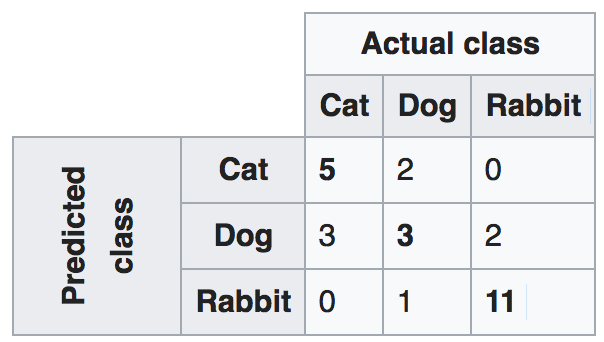

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

C:\Users\User\AppData\Local\Temp\ipykernel_7144\182277593.py:37: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  confusion_matrix = np.zeros((10,10), np.int)


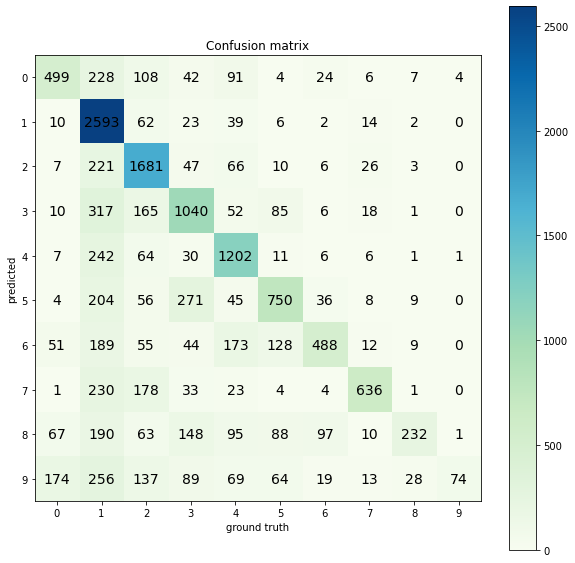

In [20]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), np.int)
    
    return np.bincount(ground_truth * 10 + predictions, minlength=100).reshape(10, 10)

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

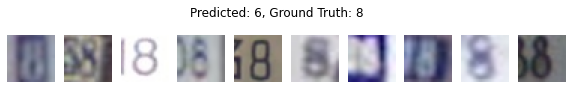

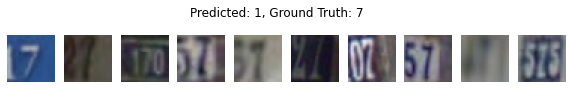

In [22]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, ground_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    indices = val_indices[(ground_truth == gt_class) & (predictions == predicted_class)]
    visualize_images(indices, data, title=f"Predicted: {predicted_class}, Ground Truth: {gt_class}")

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [26]:
nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10)
)

best_nn = None
best_accuracy = 0

learinig_rates = [1e-3, 1e-2, 1e-1, 0.003]
reg_strengths = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
epochs = [5, 10, 15]
for lr in learinig_rates:
    for reg in reg_strengths:
        for epoch in epochs:            
            optimizer = optim.SGD(nn_model.parameters(), lr=lr, weight_decay=reg)
            schedulers = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
            loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                                   optimizer, schedulers, epoch)
            if val_history[-1] > best_accuracy:
                best_accuracy = val_history[-1]
                best_nn = nn_model
            print("1 Train complete")
print(f'best accuracy {best_accuracy}')

Average loss: 2.087068, Train accuracy: 0.289783, Val accuracy: 0.421200
Average loss: 1.789357, Train accuracy: 0.460943, Val accuracy: 0.514026
Average loss: 1.666883, Train accuracy: 0.522592, Val accuracy: 0.549587
Average loss: 1.608096, Train accuracy: 0.551189, Val accuracy: 0.581940
Average loss: 1.565333, Train accuracy: 0.574515, Val accuracy: 0.589721
1 Train complete
Average loss: 1.530065, Train accuracy: 0.587704, Val accuracy: 0.613269
Average loss: 1.467105, Train accuracy: 0.615654, Val accuracy: 0.644939
Average loss: 1.420092, Train accuracy: 0.639713, Val accuracy: 0.663026
Average loss: 1.400345, Train accuracy: 0.649422, Val accuracy: 0.678384
Average loss: 1.381287, Train accuracy: 0.659813, Val accuracy: 0.672514
Average loss: 1.371409, Train accuracy: 0.662321, Val accuracy: 0.678930
Average loss: 1.362882, Train accuracy: 0.669181, Val accuracy: 0.682752
Average loss: 1.357382, Train accuracy: 0.671757, Val accuracy: 0.689509
Average loss: 1.353451, Train accu

Average loss: 0.478817, Train accuracy: 0.867044, Val accuracy: 0.850522
Average loss: 0.468633, Train accuracy: 0.869467, Val accuracy: 0.855436
Average loss: 0.468316, Train accuracy: 0.870338, Val accuracy: 0.852365
Average loss: 0.465076, Train accuracy: 0.872453, Val accuracy: 0.855505
Average loss: 0.464230, Train accuracy: 0.871208, Val accuracy: 0.857484
Average loss: 0.458728, Train accuracy: 0.873324, Val accuracy: 0.855368
Average loss: 0.459857, Train accuracy: 0.872624, Val accuracy: 0.854003
Average loss: 0.459226, Train accuracy: 0.873562, Val accuracy: 0.857484
Average loss: 0.456627, Train accuracy: 0.874108, Val accuracy: 0.857143
Average loss: 0.457255, Train accuracy: 0.872795, Val accuracy: 0.856051
1 Train complete
Average loss: 0.549785, Train accuracy: 0.837184, Val accuracy: 0.841513
Average loss: 0.535589, Train accuracy: 0.841723, Val accuracy: 0.832639
Average loss: 0.489787, Train accuracy: 0.859144, Val accuracy: 0.849021
Average loss: 0.479972, Train accu

In [28]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(best_nn, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8400
